In [59]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers


# Loading and Preprocessing the data

In [60]:
train_path = '/kaggle/input/vae-dataset/new_data/train'
val_path = '/kaggle/input/vae-dataset/new_data/validation'

In [61]:
# Image size and batch size
img_size = (128, 128)
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# No Data Augmentation for Validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=False  # No need to shuffle validation data
)

Found 135 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


# Building the Model

In [62]:
# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [63]:
# Define input shape
input_shape = (*img_size, 3)  # 3 channels for RGB images

latent_dim = 30
num_channels = 3
original_dim = 128 * 128 * 3

## Encoder

In [64]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model

# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)  # Add another Conv2D layer

conv_shape = K.int_shape(x)
x = Flatten()(x)
h = Dense(256, activation='relu')(x)

encoder = Model(inputs, h, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               134217984 
                                                                 
Total params: 134311232 (512.36 MB)
Trainable params: 13431

In [65]:
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

print(z_mean.shape)

(None, 30)


In [66]:
# Use Lambda layer to implement the sampling function
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [67]:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 128, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_7 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 64, 64, 128)          73856     ['conv2d_7[0][0]']            
                                                                                            

## Decoder

In [68]:
conv_shape[1] * conv_shape[2] * conv_shape[3]

524288

In [69]:
conv_shape[1], conv_shape[2], conv_shape[3]

(64, 64, 128)

In [70]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras.models import Model

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(latent_inputs)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

# Conv2DTranspose layers without BatchNormalization
x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)

x = Conv2DTranspose(64, 3, padding='same', activation='relu')(x)

x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)

# Output layer
outputs = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
print(decoder.summary())


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 524288)            16252928  
                                                                 
 reshape_3 (Reshape)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 64, 64, 128)       147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 64, 64, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 128, 128, 32)      1846

In [71]:
# VAE Model
vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name='vae')

print(vae.summary())

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 30),              134326652 
                              (None, 30),                        
                              (None, 30)]                        
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       16493635  
                                                                 
Total params: 150820287 (575.33 MB)
Trainable params: 150820287 (575.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Loss function

In [72]:
# Reshape the input and outputs for loss calculation
input_flatten = K.flatten(inputs)
vae_outputs_flatten = K.flatten(vae_outputs)

In [73]:
reconstruction_loss = keras.losses.binary_crossentropy(input_flatten, vae_outputs_flatten)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

## Training the model

In [74]:
vae.compile(optimizer=Adam())

In [75]:
# Train the VAE model
history = vae.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    validation_steps=val_generator.samples // batch_size,  # Number of steps per validation epoch
)

Epoch 1/300
4/4 [==============================] - 9s 681ms/step - loss: 35123.8359 - val_loss: 34057.4688
Epoch 2/300
4/4 [==============================] - 2s 647ms/step - loss: 34011.2227 - val_loss: 33958.2422
Epoch 3/300
4/4 [==============================] - 2s 479ms/step - loss: 33825.8594 - val_loss: 33838.7383
Epoch 4/300
4/4 [==============================] - 2s 489ms/step - loss: 33631.1953 - val_loss: 33463.0781
Epoch 5/300
4/4 [==============================] - 2s 504ms/step - loss: 33242.1445 - val_loss: 33148.0977
Epoch 6/300
4/4 [==============================] - 2s 656ms/step - loss: 33157.2773 - val_loss: 33025.4297
Epoch 7/300
4/4 [==============================] - 2s 607ms/step - loss: 33118.0000 - val_loss: 33034.1367
Epoch 8/300
4/4 [==============================] - 2s 482ms/step - loss: 33055.4062 - val_loss: 33172.6602
Epoch 9/300
4/4 [==============================] - 2s 663ms/step - loss: 33098.9922 - val_loss: 33132.7422
Epoch 10/300
4/4 [===================

# Plotting

2/2 [==============================] - 0s 35ms/step


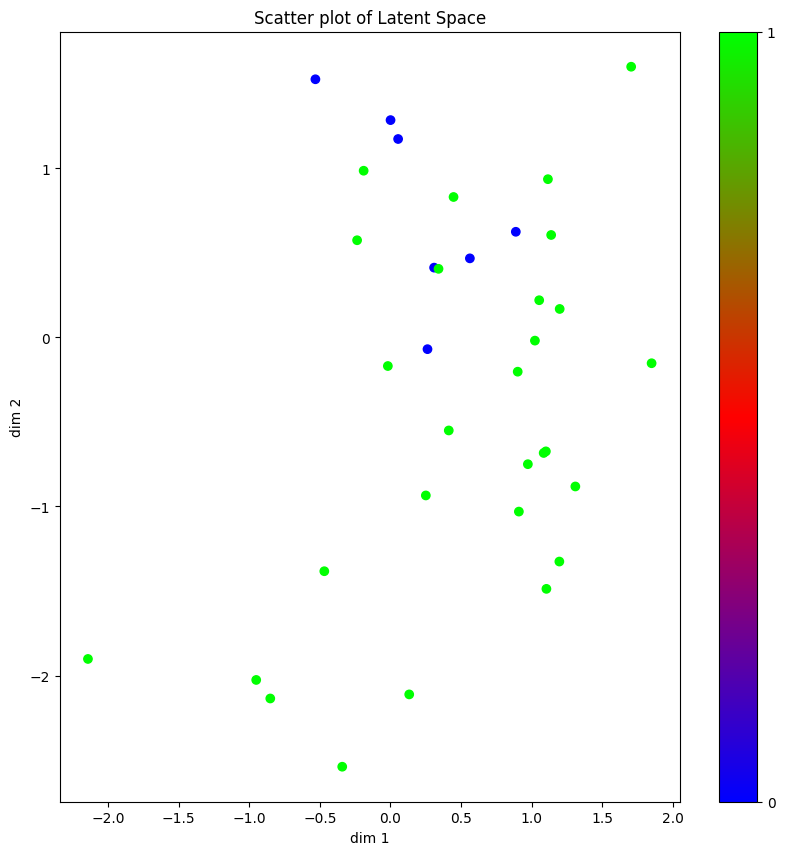

In [76]:
# Assuming you have the 'encoder' model defined
mu, _, _ = encoder.predict(val_generator)

# Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
scatter = plt.scatter(mu[:, 0], mu[:, 1], c=val_generator.labels, cmap='brg')  # Assuming you have labels in the generator
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar(scatter, ticks=np.unique(val_generator.labels))
plt.title('Scatter plot of Latent Space')
plt.show()

1/1 [==============================] - 0s 23ms/step


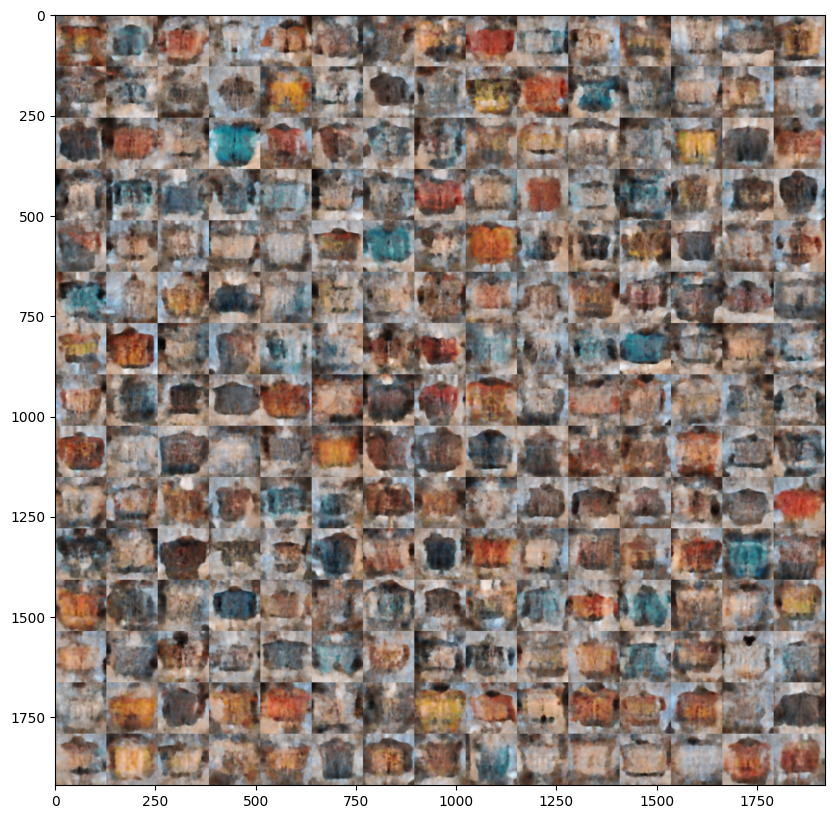

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Set the size of the grid
n = 15
figure = np.zeros((img_size[0] * n, img_size[1] * n, num_channels))

# Create a grid of latent variables
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# Generate images for each point in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.random.normal(size=(1, latent_dim))  # latent_dim is 100
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_size[0], img_size[1], num_channels)
        figure[i * img_size[0]: (i + 1) * img_size[0], j * img_size[1]: (j + 1) * img_size[1]] = digit

# Check the size of the figure array before reshaping
expected_size = img_size[0] * n * img_size[1] * n * num_channels
if figure.size != expected_size:
    raise ValueError(f"Unexpected size for the 'figure' array. Expected {expected_size}, but got {figure.size}.")

# Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1], num_channels))

# Plot the grid of images
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()

# -----------

In [78]:
# Define a function to plot images based on latent space variables
def plot_latent_space(decoder, n=5):
    # Set the size of the grid
    figure = np.zeros((img_size[0] * n, img_size[1] * n, num_channels))

    # Create a grid of latent variables
    grid_x = np.linspace(-5, 5, n)
    grid_y = np.linspace(-5, 5, n)[::-1]

    # Generate images for each point in the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.normal(size=(1, latent_dim))  # latent_dim is 100
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size[0], img_size[1], num_channels)
            figure[i * img_size[0]: (i + 1) * img_size[0], j * img_size[1]: (j + 1) * img_size[1]] = digit

    # Check the size of the figure array before reshaping
    expected_size = img_size[0] * n * img_size[1] * n * num_channels
    if figure.size != expected_size:
        raise ValueError(f"Unexpected size for the 'figure' array. Expected {expected_size}, but got {figure.size}.")

    # Reshape for visualization
    fig_shape = np.shape(figure)
    figure = figure.reshape((fig_shape[0], fig_shape[1], num_channels))

    # Plot the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.show()

In [79]:
# Define a function to generate images based on slider values
def generate_images(num_images=5, max_images=30):
    plot_latent_space(decoder, n=num_images)

In [80]:
from ipywidgets import interact, IntSlider

# Interact function to create sliders and generate images based on the slider values
interact(
    generate_images,
    num_images=IntSlider(min=1, max=30, step=1, value=5),
    max_images=IntSlider(min=5, max=100, step=1, value=30)
)

interactive(children=(IntSlider(value=5, description='num_images', max=30, min=1), IntSlider(value=30, descrip…

<function __main__.generate_images(num_images=5, max_images=30)>